# Spotify Assignment

#### Author Information:

Oguz Semerci<br>
oguz.semerci@gmail.com<br>
(617) 756-8440

## Introduction

In this report we analyze on-time performance [data](http://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time) of domestic flights
in the USA for the month of December, 2014. Delays in airline traffic
can be attributed to many factors such as weather, security,
scheduling inefficiencies, imbalance between demand and capacity at
the airports as well as propagation of late arrivals and departures
between connecting flights. Our goal is to reveal patterns, or lack
thereof, of flight delays due to airport characteristics, carrier and
date and time of travel. More involved modelling of different possible
effects mentioned above is out of the scope of this report.

There are three sections in the report. Since iPython notebook is
chosen as the format, source codes implementing the described
computations are also presented in each section. Section I describes
the steps for loading, merging and cleaning the data sets in hand. An
exploratory analysis of selected attributes and their relation to
on-time performance was given in Section II. Section III describes a logistic regression model for the estimation of delay probability. Finally, Section IV summarizes the report and provides some future directions.

## I. Data Preperation

Let us first import the modules that will be used:

In [1]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
import csv
import xlrd
%matplotlib inline

### Load Additional Data Sets

In [4]:
book  = xlrd.open_workbook('airports_new.xlt')
sheet = book.sheet_by_index(0)
airport_data = [[sheet.cell_value(i,j) for j in range(sheet.ncols)] for i in range(sheet.nrows)]
#convert to dictionary for easy loop-up
airport_dict = {}
for j in range(len(airport_data[0])):
    key = airport_data[0][j]
    airport_dict[key] = [airport_data[i][j] for i in range(1,len(airport_data))]

book = xlrd.open_workbook('carriers.xls')
sheet = book.sheet_by_index(0)
#every other row in 'carrriers.xls' sheet is empty'
carrier_data = [[sheet.cell_value(i,j) for j in range(sheet.ncols)]
                for i in range(0,sheet.nrows,2)]
#convert to dictionary for easy look-up
carrier_dict = {}
for j in range(len(carrier_data[0])):
    key = carrier_data[0][j]
    carrier_dict[key] = [carrier_data[i][j] for i in range(1,len(carrier_data))]

print('Fields in the additional carrier data set:')
print('-----------------------------------------')
for key in carrier_dict.keys():
    print(key)
print('')
print('Fields in the additional airport data set:')
print('-----------------------------------------')
for key in airport_dict.keys():
    print(key)

Fields in the additional carrier data set:
-----------------------------------------
Code
Description

Fields in the additional airport data set:
-----------------------------------------
state
lat
city
long
country
iata
airport


### Load On-Time Performance Data

We downloaded the on time performance data from the [Bureau of Transportation Statistics](http://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time) for December, 2014.

In [5]:
delay_data = []
f = open('532747144_T_ONTIME.csv', 'r')
reader = csv.reader(f)
delay_data_header = next(reader,None)
for row in reader:
    delay_data.append(row)
f.close()

#### List of the fields in the delay_data array for reference:

In [6]:
for i,s in enumerate(delay_data_header):
    print(str(i) + ': ' + s)

0: MONTH
1: DAY_OF_MONTH
2: DAY_OF_WEEK
3: UNIQUE_CARRIER
4: ORIGIN
5: ORIGIN_CITY_NAME
6: ORIGIN_STATE_ABR
7: DEST
8: DEST_CITY_NAME
9: DEST_STATE_ABR
10: DEP_TIME
11: DEP_DELAY
12: TAXI_OUT
13: TAXI_IN
14: ARR_TIME
15: ARR_DELAY
16: CANCELLED
17: ACTUAL_ELAPSED_TIME
18: AIR_TIME
19: DISTANCE
20: CARRIER_DELAY
21: WEATHER_DELAY
22: NAS_DELAY
23: SECURITY_DELAY
24: LATE_AIRCRAFT_DELAY
25: 


Last column is empty. Let's remove it from our data.

In [7]:
delay_data = [d[:-1] for d in delay_data]
delay_data_header = delay_data_header[:-1]

### Remove Canceled Flights and Flights with Missing Information

We are concerned with conducted flights. Therefore let us remove the canceled flights from the data.

In [8]:
#remove cancelled flights
delay_data = [d for d in delay_data if d[16] != '1.00']

Now a quick glance and printing some of the rows reveal that some flights have missing information. We remove them from the data for sake completeness. Note that rows 20:24 are empty when arrival delay <= 0.

In [9]:
#determine the rows with missing data:
rows_with_missing_data = []
for i in range(len(delay_data)):
    for j in range(20):
        if len(delay_data[i][j]) == 0:
            rows_with_missing_data.append(i)
            break

For example observe that the flight below is missing arrival delay and air time information. This is possibly because that particular flight was diverted (hopefully).

In [10]:
i = rows_with_missing_data[0]
print('Example row in the data with missing entries:\n')
for j in range(len(delay_data[i])):
    print(delay_data_header[j] + ': ' + str(delay_data[i][j]))

Example row in the data with missing entries:

MONTH: 12
DAY_OF_MONTH: 14
DAY_OF_WEEK: 7
UNIQUE_CARRIER: AA
ORIGIN: DFW
ORIGIN_CITY_NAME: Dallas/Fort Worth, TX
ORIGIN_STATE_ABR: TX
DEST: HNL
DEST_CITY_NAME: Honolulu, HI
DEST_STATE_ABR: HI
DEP_TIME: 1935
DEP_DELAY: 390.00
TAXI_OUT: 30.00
TAXI_IN: 5.00
ARR_TIME: 0143
ARR_DELAY: 
CANCELLED: 0.00
ACTUAL_ELAPSED_TIME: 
AIR_TIME: 
DISTANCE: 3784.00
CARRIER_DELAY: 
WEATHER_DELAY: 
NAS_DELAY: 
SECURITY_DELAY: 
LATE_AIRCRAFT_DELAY: 


In [11]:
#remove rows with missing entries:
delay_data = [delay_data[i] for i in range(len(delay_data)) if i not in rows_with_missing_data]

Now let's convert the fields with numerical values to float. Also note that delay type (rows[20:24]) are empty if arrival delay <= 0. We will fill those empty cells with zeros.

In [12]:
float_index = set([11,12,13,15,17,18,19,20,21,22,23,24])
for i in range(len(delay_data)):
    for j in float_index:
        if len(delay_data[i][j]) > 0:
            delay_data[i][j] = float(delay_data[i][j])
        else:
            #delay type fields
            delay_data[i][j] = 0.0
            
int_index = set([1,2])
for i in range(len(delay_data)):
    for j in int_index:
        delay_data[i][j] = int(delay_data[i][j])

### Keep data only from the busiest airports

Now, we assume that the dynamics of busy airports might be significantly different that the ones with less busy ones. We would like to discard flights to and from smaller aiports so that the delay time dynamics are somewhat similar for each data point. For this aim we sorted all the airports with respect to total number of incoming and outgoing flights in December 2015. We decide the number of airports to be investigated to be 50 via visual inspection of number of flights at busiest airports:

In [15]:
#get the list of unique carrires:
carrier_ID = set()
airport_ID = set()
for d in delay_data:
    carrier_ID.add(d[3])
    airport_ID.add(d[4])
    airport_ID.add(d[7])
    
#count total arrivals and departures from each airport
flight_count_dict = {iata: 0 for iata in airport_ID}
for d in delay_data:
    flight_count_dict[d[4]] += 1
    flight_count_dict[d[7]] += 1

pairs = []
for key, value in flight_count_dict.items():
    pairs.append((key,value))

#sort airports according to 
pairs.sort(key = lambda x: x[1], reverse = True)

#### Decide cut-off point via visual inspections

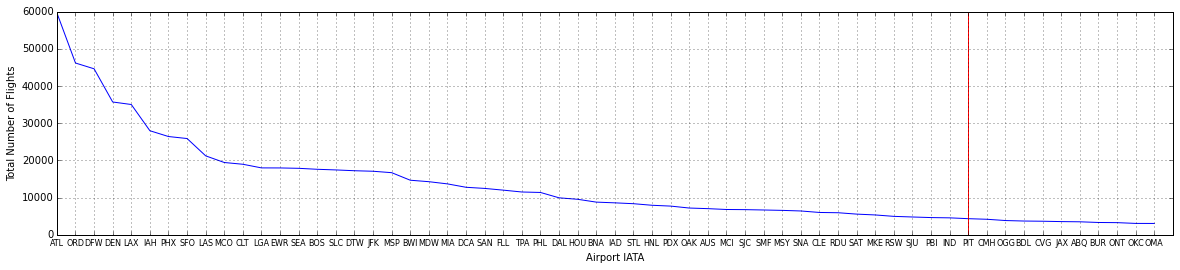


Use data from 50 most busy airports according to number of total incoming and outgoing domestic flights


In [16]:
c = [c for a,c in pairs]
a = [a for a,c in pairs]
plt.figure(figsize = (20,4))
N = 60
plt.plot(c[:N])
plt.xticks(range(N), a[:N], fontsize = 8)
plt.ylabel('Total Number of Flights')
plt.xlabel('Airport IATA')
plt.grid()
plt.axvline(49, color = 'r')
plt.show()

print('\n'+'Use data from 50 most busy airports according to number of total incoming and outgoing domestic flights')


#### Remove data from non-busy airports

In [17]:
airports_to_keep = [a for a,c in pairs[:52]]
delay_data2 = [d for d in delay_data if (d[4] in airports_to_keep and d[7] in airports_to_keep)]
print('Size of the dataset is reduced from ' + str(len(delay_data)) + ' to ' + str(len(delay_data2)))
#let's delete the large dataset
delay_data = delay_data2

Size of the dataset is reduced from 469400 to 298775


Now let's merge information of carriers and airports into two dictionaries 'carrier_info' and 'airport_info' for easy access during analysis.

#### Get Carrier Information

In [18]:
#find out carrier names from carrier_data
carrier_info = {}
for code in carrier_ID:
    k = carrier_dict['Code'].index(code)
    carrier_info[code] = carrier_dict['Description'][k]    

#### Get Airport Information

In [19]:
airport_info = {}
for iata in airports_to_keep:
    k = airport_dict['iata'].index(iata)
    airport_info[iata] = {key: airport_dict[key][k] for key in airport_dict.keys()}

### Removal of outliers with very large delay times

Above example also reveals that some departure delays are ridiclously high. We can consider them outliers as they are most pbobabably caused by some irrelevant incident beyond the scope of this investigation. Let's plot the histogram for departure delays and determine a cut-off point for departure time for outliers. Note that early arrivals and departures are given with negative values. Alternatively we could take 95th percentile. Let's investigate:

In [20]:
dep_delay_time_vector = [d[11] for d in delay_data]
arr_delay_time_vector = [d[15] for d in delay_data]
print('Departure Delay Stats in minutes:')
print('--------------------------------')
print('95th percentile: ' + str(np.percentile(dep_delay_time_vector, 95)))
print('75th percentile: ' + str(np.percentile(dep_delay_time_vector, 75)))
print('5th percentile : ' + str(np.percentile(dep_delay_time_vector, 5))) 
print('median         : ' + str(np.median(dep_delay_time_vector)))
print('mean           : ' + str(np.mean(dep_delay_time_vector)))
print('std            : ' + str(np.std(dep_delay_time_vector)))
print('')
print('Arrival Delay Stats in minutes:')
print('--------------------------------')
print('95th percentile: ' + str(np.percentile(arr_delay_time_vector, 95)))
print('75th percentile: ' + str(np.percentile(arr_delay_time_vector, 75)))
print('5th percentile : ' + str(np.percentile(arr_delay_time_vector, 5))) 
print('median         : ' + str(np.median(arr_delay_time_vector)))
print('mean           : ' + str(np.mean(arr_delay_time_vector)))
print('std            : ' + str(np.std(arr_delay_time_vector)))

Departure Delay Stats in minutes:
--------------------------------
95th percentile: 69.0
75th percentile: 12.0
5th percentile : -8.0
median         : 0.0
mean           : 11.4724223914
std            : 35.9036024956

Arrival Delay Stats in minutes:
--------------------------------
95th percentile: 68.0
75th percentile: 13.0
5th percentile : -25.0
median         : -2.0
mean           : 6.64594427245
std            : 38.4619319666


Let's plot histograms for departure and arrival delays in December 2015, as well as scatter plot for departure and arrival delays. Note that we strict the range of data points to [5-95]th percentile for arrival and departure delay histograms.

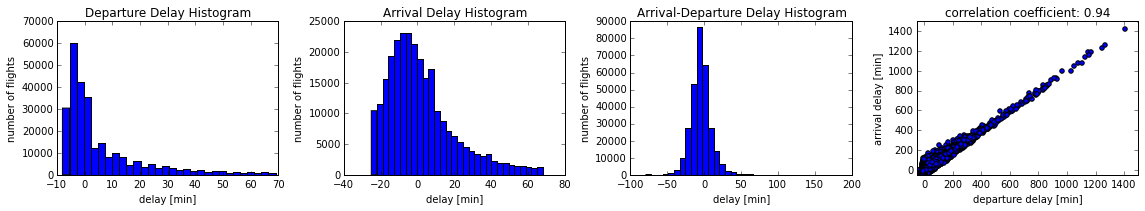

In [21]:
arr_5th = np.percentile(arr_delay_time_vector, 5)
arr_95th = np.percentile(arr_delay_time_vector, 95)
dep_5th = np.percentile(dep_delay_time_vector, 5)
dep_95th = np.percentile(dep_delay_time_vector, 95)

fig = plt.figure(figsize = (16,3))
ax1 = plt.subplot(141)
ax2 = plt.subplot(142)
ax3 = plt.subplot(143)
ax4 = plt.subplot(144)

_,_,_ = ax1.hist(dep_delay_time_vector, bins = 30, range = [dep_5th, dep_95th])
ax1.set_xlabel('delay [min]')
ax1.set_ylabel('number of flights')
ax1.set_title('Departure Delay Histogram')

_,_,_ = ax2.hist(arr_delay_time_vector, bins = 30, range = [arr_5th, arr_95th])
ax2.set_xlabel('delay [min]')
ax2.set_title('Arrival Delay Histogram')
ax2.set_ylabel('number of flights')

_,_,_ = ax3.hist([a-b for a,b in zip(arr_delay_time_vector,dep_delay_time_vector)], bins = 30)
ax3.set_xlabel('delay [min]')
ax3.set_title('Arrival-Departure Delay Histogram')
ax3.set_ylabel('number of flights')


corr_coef = np.corrcoef(dep_delay_time_vector,arr_delay_time_vector)[0,1]
ax4.scatter(dep_delay_time_vector,arr_delay_time_vector)
ax4.set_xlim([-50,1500])
ax4.set_ylim([-50,1500])
ax4.set_title('correlation coefficient: %2.2f' %(corr_coef) )
ax4.set_xlabel('departure delay [min]')
ax4.set_ylabel('arrival delay [min]')

plt.tight_layout()
plt.show()


As expected, departure delays and arrival delay are highly correlated. Let us first remove outliers in terms of departure delay. 95th percentile gives us the departure delay of 69 minutes, which is not too drastic. Therefore, we remove flights with departure delay larger than 69 minutes. Note the very large departure delay times in the scatter plot. We reason that those extreme values are assumed to be governed by unusual events such as storms or errupting volcanos, which are needed to be removed from our data.

In [22]:
N = len(dep_delay_time_vector)
delay_data = [delay_data[i] for i in range(N) if dep_delay_time_vector[i] < 69]

Next, let us see if we have outliers in the arrival delays after the removal of departure delay outliers.

Departure Delay Stats in minutes:
--------------------------------
95th percentile: 41.0
75th percentile: 9.0
5th percentile : -8.0
median         : -1.0
mean           : 5.2707831028
std            : 15.2669310425

Arrival Delay Stats in minutes:
--------------------------------
95th percentile: 41.0
75th percentile: 9.0
5th percentile : -26.0
median         : -3.0
mean           : 0.387776179801
std            : 20.1563924451


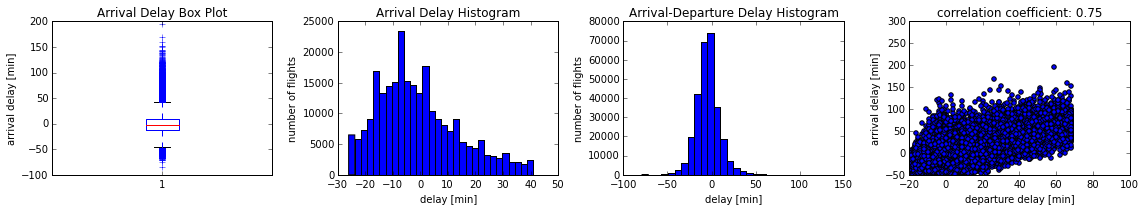

In [23]:
dep_delay_time_vector = [d[11] for d in delay_data]
arr_delay_time_vector = [d[15] for d in delay_data]
print('Departure Delay Stats in minutes:')
print('--------------------------------')
print('95th percentile: ' + str(np.percentile(dep_delay_time_vector, 95)))
print('75th percentile: ' + str(np.percentile(dep_delay_time_vector, 75)))
print('5th percentile : ' + str(np.percentile(dep_delay_time_vector, 5))) 
print('median         : ' + str(np.median(dep_delay_time_vector)))
print('mean           : ' + str(np.mean(dep_delay_time_vector)))
print('std            : ' + str(np.std(dep_delay_time_vector)))
print('')
print('Arrival Delay Stats in minutes:')
print('--------------------------------')
print('95th percentile: ' + str(np.percentile(arr_delay_time_vector, 95)))
print('75th percentile: ' + str(np.percentile(arr_delay_time_vector, 75)))
print('5th percentile : ' + str(np.percentile(arr_delay_time_vector, 5))) 
print('median         : ' + str(np.median(arr_delay_time_vector)))
print('mean           : ' + str(np.mean(arr_delay_time_vector)))
print('std            : ' + str(np.std(arr_delay_time_vector)))

arr_5th = np.percentile(arr_delay_time_vector, 5)
arr_95th = np.percentile(arr_delay_time_vector, 95)
dep_5th = np.percentile(dep_delay_time_vector, 5)
dep_95th = np.percentile(dep_delay_time_vector, 95)

fig = plt.figure(figsize = (16,3))
ax1 = plt.subplot(141)
ax2 = plt.subplot(142)
ax3 = plt.subplot(143)
ax4 = plt.subplot(144)

ax1.boxplot(arr_delay_time_vector)
ax1.set_ylabel('arrival delay [min]')
ax1.set_title('Arrival Delay Box Plot')

_,_,_ = ax2.hist(arr_delay_time_vector, bins = 30, range = [arr_5th, arr_95th])
ax2.set_xlabel('delay [min]')
ax2.set_title('Arrival Delay Histogram')
ax2.set_ylabel('number of flights')

_,_,_ = ax3.hist([a-b for a,b in zip(arr_delay_time_vector,dep_delay_time_vector)], bins = 30)
ax3.set_xlabel('delay [min]')
ax3.set_title('Arrival-Departure Delay Histogram')
ax3.set_ylabel('number of flights')


corr_coef = np.corrcoef(dep_delay_time_vector,arr_delay_time_vector)[0,1]
ax4.scatter(dep_delay_time_vector,arr_delay_time_vector)
ax4.set_xlim([-20,100])
ax4.set_ylim([-50,300])
ax4.set_title('correlation coefficient: %2.2f' %(corr_coef) )
ax4.set_xlabel('departure delay [min]')
ax4.set_ylabel('arrival delay [min]')

plt.tight_layout()
plt.show()

Notice the correlation between departure delay and arrival delay is reduced to 0.75.  The distribution of the difference of arrival and departure delays has a peaked shape and most of the points are in the [-50,50] minutes range. Scatter plot also reveals that points with arrival time greater than ~125 minutes are somewhat outside of the big cluster of points. With these observations we assume arrival delays greater than 125 minutes are outliers. It would have been interesting to investigate the the causes of these big delay times. However we are concerned with common patterns in the on-time performance of airline traffic.

In [24]:
N = len(arr_delay_time_vector)
delay_data = [delay_data[i] for i in range(N) if arr_delay_time_vector[i] < 125]

### Finally, Let's convert delay_data to a set of dictionaries for easy access

In [25]:
delay_data_dict = {}
for j in range(len(delay_data_header)):
    key = delay_data_header[j]
    delay_data_dict[key] = [delay_data[i][j] for i in range(len(delay_data))]

In [26]:
#let's approximate arrival and departure times by only their hour
delay_data_dict['ARR_TIME'] = [round( float(v)*1e-2 ) for v in delay_data_dict['ARR_TIME']]
delay_data_dict['DEP_TIME'] = [round( float(v)*1e-2 ) for v in delay_data_dict['DEP_TIME']]

### Let's Summarize the availabe data

The dictionart '_*airport_info*_' indexed by the 'iata' code. We remind the reader that only the busiest 52 US airports were kept in the data set. Each airport has further information on its location. Let's look at Boston's Logan Airport as an example

In [27]:
print("Example: Info on Logan Airport: \n")
for key,value in airport_info['BOS'].items():
    print(key + ': ' + str(value))

Example: Info on Logan Airport: 

state: MA
iata: BOS
city: Boston
long: -71.00517917
country: USA
lat: 42.3643475
airport: Gen Edw L Logan Intl


The dictionary '*carrier_info*' pairs carrier codes with airline names:

In [28]:
for key,value in carrier_info.items():
    print(key + ': ' + value)

US: US Airways Inc. (Merged with America West 9/05. Reporting for both starting 10/07.)
MQ: American Eagle Airlines Inc.
DL: Delta Air Lines Inc.
HA: Hawaiian Airlines Inc.
AA: American Airlines Inc.
F9: Frontier Airlines Inc.
AS: Alaska Airlines Inc.
EV: Atlantic Southeast Airlines
FL: AirTran Airways Corporation
UA: United Air Lines Inc.
B6: JetBlue Airways
VX: Virgin America
WN: Southwest Airlines Co.
OO: Skywest Airlines Inc.


In [29]:
#we will not delve into data before 07. Let's make US: US Airways
carrier_info['US'] = 'US Airways Inc.'

The main data, '*delay_data_dict*' is also in a dictionary format where keys are the fields and each field has all the samples for that field (feature) in the data set. Here are the fields one more time for reference. Note that 'UNIQUE_CARRIER' corresponds to the carrier codes in the *carrier_info* dictionary, whereas DEST and ORIGIN fields are the 'iata' id's in the *airpot_info* dictionary.

In [30]:
for key in delay_data_dict.keys():
    print(key) 

SECURITY_DELAY
DEST
CANCELLED
DAY_OF_WEEK
DISTANCE
ARR_DELAY
ORIGIN_STATE_ABR
TAXI_IN
CARRIER_DELAY
DEP_DELAY
LATE_AIRCRAFT_DELAY
DAY_OF_MONTH
ORIGIN_CITY_NAME
DEST_CITY_NAME
AIR_TIME
UNIQUE_CARRIER
ORIGIN
TAXI_OUT
WEATHER_DELAY
ACTUAL_ELAPSED_TIME
DEP_TIME
NAS_DELAY
DEST_STATE_ABR
ARR_TIME
MONTH


By the way let's make sure that delay_data_dict does not have flights information on carrriers that are not known to us:

In [31]:
s1 = set(delay_data_dict['UNIQUE_CARRIER'])
s2 = set(carrier_info.keys())
print(list(s1-s2))
print(list(s2-s1))

[]
[]


## II. Exploratory Analysis to Reveal Features That Effect On-time Performance

Let's look at the distribution of delay causes among all delays in 12/2015:

In [32]:
delays = [sum(delay_data_dict['CARRIER_DELAY']),
          sum(delay_data_dict['WEATHER_DELAY']),
          sum(delay_data_dict['NAS_DELAY']),
          sum(delay_data_dict['SECURITY_DELAY']),
          sum(delay_data_dict['LATE_AIRCRAFT_DELAY'])]
total  = sum(delays)
delays = [100*d/total for d in delays]
print('Delay Cause Percentages:')
print('-----------------------')
print('Carrier delay  : ' + str(delays[0]))
print('Weather delay  : ' + str(delays[1]))
print('NAS delay      : ' + str(delays[2]))
print('Security delay : ' + str(delays[3]))
print('Late Aircraft  : ' + str(delays[4]))

Delay Cause Percentages:
-----------------------
Carrier delay  : 28.935177204838045
Weather delay  : 1.5712733123732263
NAS delay      : 35.513930483504794
Security delay : 0.15779422660765585
Late Aircraft  : 33.82182477267628


One can say that most of the delays are caused by 'relative congestion' at the airports as more than 98% of the delays are caused by carrier, NAS and late aircraft related reasons. Weather also seem to be effecting the on-time performance. Please follow this [link](http://www.rita.dot.gov/bts/help/aviation/html/understanding.html) for definitions of types of delays.

### On Time Performance Analysis of Airports and Carriers

Airline traffic network is extremely complex with interactions of many variables and propagation of delays during the day. Therefore we need to be careful in our definition of late flights. We already establied the fact that departure delays are highly correlated with arrival delays.

We will use the following definitions for delay at airports:

- At the origin departure delay larger than 15 minutes is counted as late flight
- At the destination if the difference between arrival delay and departure delay is larger than 15 that flight is considered late. Note that this definition regarding the destination assume that there are no causes of delay when the plane is on route in the air.

For carriers, we consider only late departures.

In [33]:
N = len(delay_data_dict['ORIGIN']) # N: sample size
carrier_performance = {}
airport_performance = {}

#airport on time performance
for airport in airport_info.keys():
    #departures:
    ind = [i for i in range(N) if delay_data_dict['DEST'][i] == airport]
    total_flights   = len(ind)
    on_time_flights = sum( [delay_data_dict['DEP_DELAY'][i] <= 15 for i in ind] )
    #arrivals:
    ind = [i for i in range(N) if delay_data_dict['ORIGIN'][i] == airport]
    total_flights   += len(ind)
    on_time_flights += sum( [delay_data_dict['ARR_DELAY'][i] - delay_data_dict['DEP_DELAY'][i] <= 15 for i in ind] )

    if total_flights > 0:
        airport_performance[airport] = {'total_flights': total_flights,
                                        'on_time_flights': on_time_flights,
                                        'on_time_ratio': on_time_flights/total_flights} 

#carreir on time performance        
for carrier in carrier_info.keys():
    #departures:
    ind = [i for i in range(N) if delay_data_dict['UNIQUE_CARRIER'][i] == carrier]
    total_flights   = len(ind)
    on_time_flights = sum( [delay_data_dict['DEP_DELAY'][i] <= 15 for i in ind] )
    
    if total_flights > 0:
        carrier_performance[carrier] = {'total_flights': total_flights,
                                        'on_time_flights': on_time_flights,
                                        'on_time_ratio': on_time_flights/total_flights} 
        

#### Overall on-time performance of carriers.

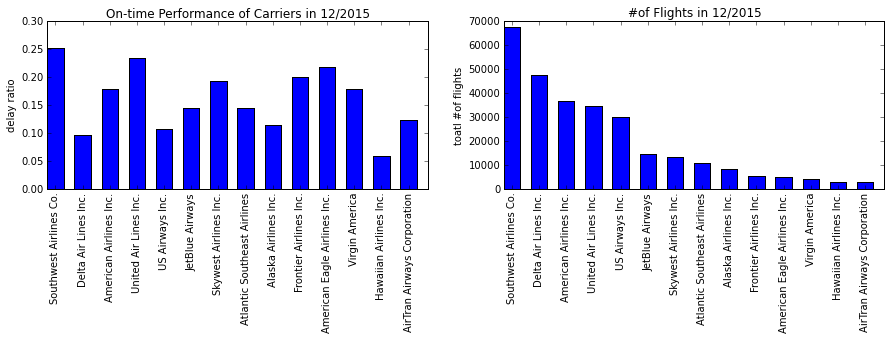

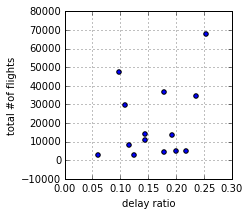

In [152]:
name = []
code = []
on_time = []
flights = []
for key in carrier_performance.keys():
    code.append(key)
    name.append(carrier_info[key])
    on_time.append(carrier_performance[key]['on_time_ratio'])
    flights.append(carrier_performance[key]['total_flights'])

name, code, on_time, flights = zip( *sorted( zip(name, code, on_time, flights), key = lambda x: x[3], reverse = True ) )

fig = plt.figure(figsize = (15,3))
width = .6
ax1 = plt.subplot(121)
ax1.bar(range(len(on_time)), [1- v for v in on_time], width = width)
ax1.set_xticks(np.arange(len(on_time)) + width/2)
ax1.set_xticklabels(name, rotation = 90)
ax1.set_title('On-time Performance of Carriers in 12/2015')
ax1.set_ylabel('delay ratio')

ax2 = plt.subplot(122)
ax2.bar(range(len(on_time)), flights, width = width)
ax2.set_xticks(np.arange(len(on_time)) + width/2)
ax2.set_xticklabels(name, rotation = 90)
ax2.set_ylabel('toatl #of flights')
ax2.set_title('#of Flights in 12/2015')
plt.show()

fig = plt.figure(figsize=(3,3))
plt.scatter([1- v for v in on_time], flights)
#plt.xticks([0.14, 0.16, 0.20, 0.26])
plt.xlabel('delay ratio')
plt.ylabel('total #of flights')
plt.grid()
plt.show()

The upper left shows that overall on-time performance varies quite a bit from carrier to carrier. Whereas no correlation between flight volume of the carrier and its on-time performance is observed. We decide to divide the carriers into performance categories according to their overall delay ratios as follows:

- no_unless_its_really_cheap : {delay ratio greater than 0.20}.
- not_bad: {delay ratio greater than 0.15 smaller or equal to 0.20}.
- way_to_go: {delay ratio smaller than or equal to 0.15}.

In [159]:
#find the airlines within each category:
no_unless_its_really_cheap = []
not_bad = []
way_to_go = []

for c,v in zip(code, on_time):
    r = 1-v
    if r > 0.20:
        no_unless_its_really_cheap.append(c)
    elif r <= 0.15:
        way_to_go.append(c)
    else:
        not_bad.append(c)

print('way_to_go carriers:')
print('------------------')
for c in way_to_go:
    print(carrier_info[c])

way_to_go carriers:
------------------
Delta Air Lines Inc.
US Airways Inc.
JetBlue Airways
Atlantic Southeast Airlines
Alaska Airlines Inc.
Hawaiian Airlines Inc.
AirTran Airways Corporation


#### Overall on-time performance of airports.

Let's visualize airport traffic and on time performance of all airports on the map of USA.

In [148]:
lat = []
lon = []
name = []
on_time = []
flights = []
for key in airport_performance.keys():
    name.append(airport_info[key]['airport'])
    lat.append(airport_info[key]['lat'])
    lon.append(airport_info[key]['long'])
    on_time.append(airport_performance[key]['on_time_ratio'])
    flights.append(airport_performance[key]['total_flights'])

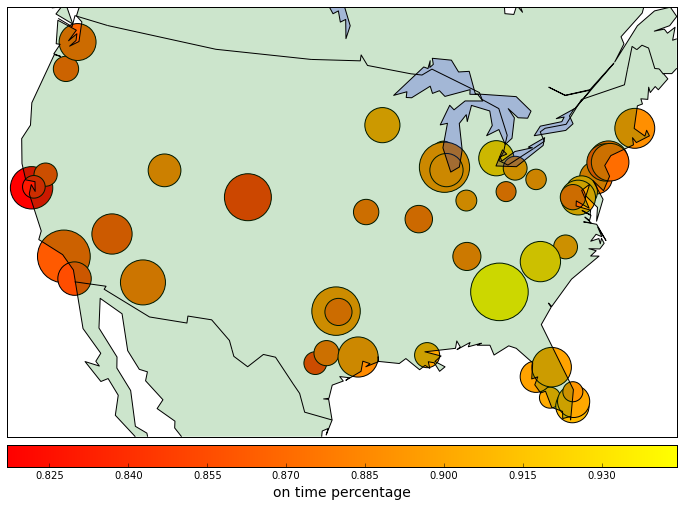

In [149]:
fig = plt.figure(figsize=[12,10])
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
m.drawcoastlines(linewidth=1)
m.fillcontinents(color = 'green', lake_color = 'blue', alpha = 0.2)
m.drawcountries(linewidth=1)
x,y = m(lon, lat)

im = m.scatter(x,y, marker = 'o', s = np.array(flights)/10, c = on_time,
          cmap = 'autumn')
cb = m.colorbar(im,'bottom')
cb.set_label('on time percentage', fontsize = '14')
plt.show()

In the map above, airport locations are shown with circles color coded accordinf to on-time performance. The area of each circle is proportional to the total number of flights at that airport. Similar to carrier and number of flights we observe no immediate relationship between flight volume and on-time percentage. One intereting question is whether there is a relationship between closeness of the airport to either of the coasts (east or west). Since longitude lines are nearly parellel to the east-west alignment of the map of the US we can measure closeness of an airport with its distance to the middle of the map in terms of longitude. The below scatter plot and delay ratio as a function of distance from the coast plots investigate this possibility.

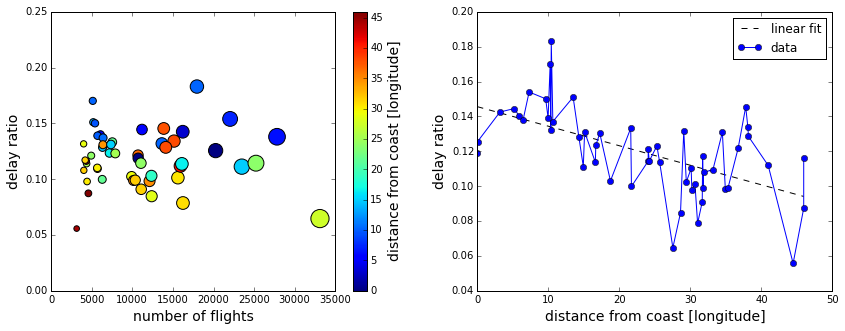

In [150]:
middle_of_map = (min(lon)+max(lon))/2.0
distance_from_coasts = abs(np.array(lon)-np.array(middle_of_map))

fig = plt.figure(figsize = (14,5))
ax1 = plt.subplot(121)
im = ax1.scatter(flights, [1-v for v in on_time], marker = 'o', s = np.array(flights)/100, c = distance_from_coasts)
#cbar3 = plt.colorbar(im3, cax=cax3, ticks=MultipleLocator(0.2), format="%.2f")
cb = plt.colorbar(im)
cb.set_label('distance from coast [longitude]', fontsize = '14')
ax1.set_xlabel('number of flights', fontsize = '14')
ax1.set_ylabel('delay ratio', fontsize = '14')

x,y = zip(*sorted(zip(distance_from_coasts, [1- v for v in on_time]), key = lambda x: x[0]))
fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit)

ax2 = plt.subplot(122)
ax2.plot(x, fit_fn(x), '--k', label = 'linear fit')
ax2.plot(x,y,'o-', label = 'data')
ax2.legend()
ax2.set_xlabel('distance from coast [longitude]', fontsize = '14')
ax2.set_ylabel('delay ratio', fontsize = '14')
plt.show()

Observing the plots above, we can say that coastal distance and delay ratio are negatively correlated. Although longitude is is a bit crude and a more precise computation of coastal distance is possible we chose to use it as a continious variable (predictor) in our model.

Finally in this section we list the busiest ten airports in the US and their on time performances.

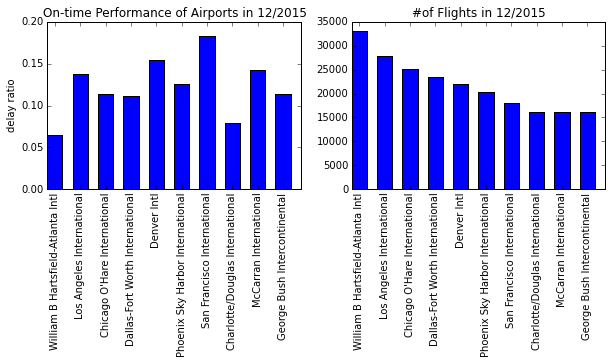

In [151]:
name, on_time, flights = zip( *sorted( zip(name, on_time, flights), key = lambda x: x[2], reverse = True ) )

fig = plt.figure(figsize = (10,3))
width = .6
ax1 = plt.subplot(121)
ax1.bar(range(10), [1-v for v in on_time[:10]], width = width)
ax1.set_xticks(np.arange(10) + width/2)
ax1.set_xticklabels(name[:10], rotation = 90)
ax1.set_title('On-time Performance of Airports in 12/2015')
ax1.set_ylabel('delay ratio')

ax2 = plt.subplot(122)
ax2.bar(range(10), flights[:10], width = width)
ax2.set_xticks(np.arange(10) + width/2)
ax2.set_xticklabels(name[:10], rotation = 90)
ax2.set_title('#of Flights in 12/2015')
plt.show()

### Analysis of on-time performance in terms of flight date and time

When considering delays for each trip what passengers are really concerned acout is the arrival delay. Also considering the correlation between departure and arrival delays as well possible accumulation of delays we only count arrival delays when analyzing daily trends.

In [100]:
total_flights_month   = [0]*32
on_time_flights_month = [0]*32
avg_delay_month       = [0]*32
total_flights_day   = [0]*8
on_time_flights_day = [0]*8
avg_delay_day       = [0]*8
total_flights_time   = [0]*25
on_time_flights_time = [0]*25
avg_delay_time       = [0]*25

N = len(delay_data_dict['ARR_DELAY']) #sample size
day_dict = {1:'mon',2:'tue',3:'wed',4:'thu',5:'fri',6:'sat',7:'sun'}
days = ['']*32

for i in range(N):
    j = delay_data_dict['DAY_OF_MONTH'][i]
    day = delay_data_dict['DAY_OF_WEEK'][i]
    t = delay_data_dict['ARR_TIME'][i]
    days[j] = day_dict[day] # keep list of days for indexing purposes    
    delay = delay_data_dict['ARR_DELAY'][i]
    
    total_flights_month[j] += 1
    total_flights_day[day] += 1
    total_flights_time[t]  += 1
    if delay <= 15:
        on_time_flights_month[j] += 1
        on_time_flights_day[day] += 1
        on_time_flights_time[t] += 1
    avg_delay_month[j] += delay
    avg_delay_day[day] += delay
    avg_delay_time[t]  += delay
avg_delay_time[24]  += avg_delay_time[0]
    
avg_delay_month = np.array(avg_delay_month[1:]) / np.array(total_flights_month[1:])
avg_delay_day   = np.array(avg_delay_day[1:]) / np.array(total_flights_day[1:])
avg_delay_time  = np.array(avg_delay_time[1:]) / np.array(total_flights_time[1:])


delay_ratio_month = 1.0 - np.array(on_time_flights_month[1:]) / np.array(total_flights_month[1:])
delay_ratio_day   = 1.0 - np.array(on_time_flights_day[1:]) / np.array(total_flights_day[1:])
delay_ratio_time  = 1.0 - np.array(on_time_flights_time[1:]) / np.array(total_flights_time[1:])

day = days[1:]

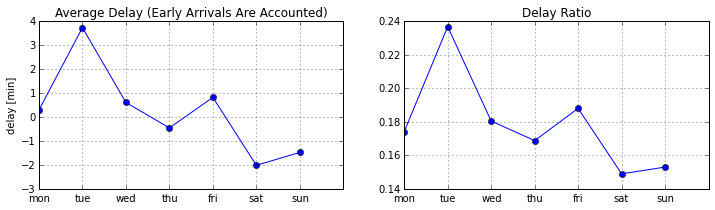

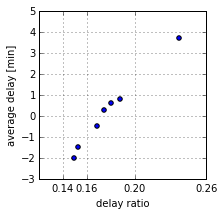

In [108]:
fig = plt.figure(figsize=(12,3))

plt.subplot(121)
plt.plot(avg_delay_day, 'o-')
plt.xticks(range(0,8), [day_dict[i] for i in range(1,8)])
plt.title('Average Delay (Early Arrivals Are Accounted)')
plt.ylabel('delay [min]')
plt.grid()

plt.subplot(122)
plt.plot(delay_ratio_day, 'o-')
plt.xticks(range(0,8), [day_dict[i] for i in range(1,8)])
plt.title('Delay Ratio')
plt.grid()
plt.show()

fig = plt.figure(figsize=(3,3))
plt.scatter(delay_ratio_day,avg_delay_day)
plt.xticks([0.14, 0.16, 0.20, 0.26])
plt.xlabel('delay ratio')
plt.ylabel('average delay [min]')
plt.grid()
plt.show()

It is interesting to observe Tuesday is the day with the highest probability of delay. Note that in 2014 Chiristmas day was Thursday. The behaviour above can be due to congestion two day before Christmas. We investigate this possibility below when we analyze the daily patterns withing the month. Here we also show the correlation between average delay in minutes and delay ratio with the scatter plot above. Similar behaviours are observed in weekly and hourly patterns.

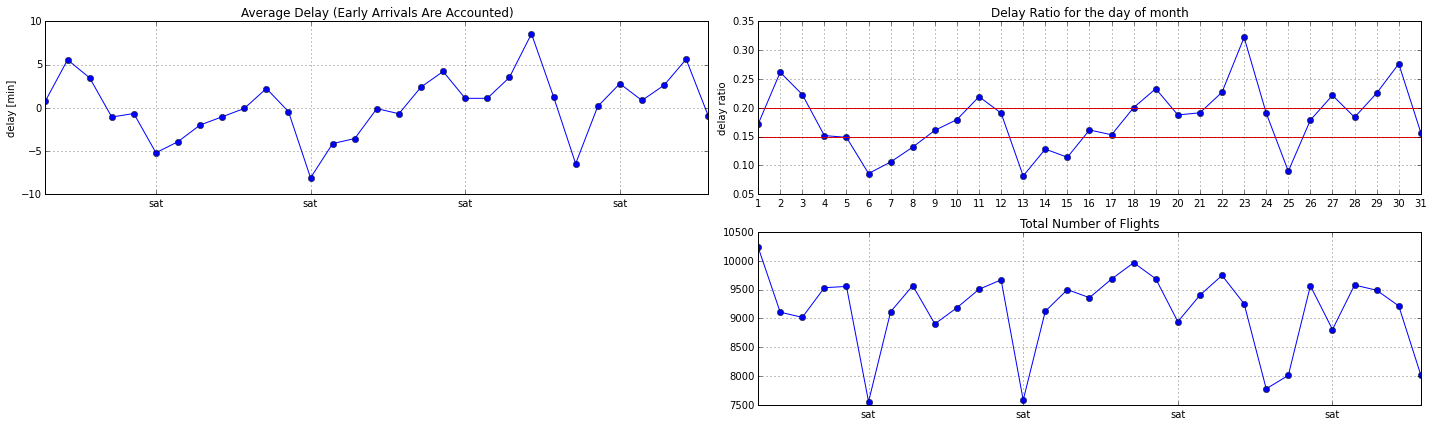

In [141]:
fig = plt.figure(figsize=(20,6))

plt.subplot(221)
plt.plot(avg_delay_month, 'o-')
plt.xticks(range(5,32,7), days[6::7])
plt.title('Average Delay (Early Arrivals Are Accounted)')
plt.ylabel('delay [min]')
plt.grid()

plt.subplot(222)
plt.plot(delay_ratio_month, 'o-')
plt.xticks(range(0,31),range(1,32))
plt.ylabel('delay ratio')
plt.title('Delay Ratio for the day of month')
plt.axhline(y = 0.20, color = 'r')
plt.axhline(y = 0.15, color = 'r')

plt.grid()

plt.subplot(224)
plt.plot(total_flights_month[1:], 'o-')
plt.xticks(range(5,32,7), days[6::7])
plt.title('Total Number of Flights')
plt.grid()
fig.tight_layout()
plt.show()

We notice the weekly periodict of delay times and ratios, where Tuesday-Friday has higher delay ration than Saturdat-Monday. More interestingly, we also notice how the cycle breaks exacyly one week before Christmas, Thursday December 18th. First Tuesday and Wednesday also tend to be different than the general pattern perhaps due to their closeness to the Thanksgiving day. Also notice two peaks on December 23rd and 30th, which were both tuesdays. Even though the number of flights are similar to the Tuesdays before delay ratios are approximately doubled. In addition Chrismas  Finally, we note that day-of-month analysis is more informative that the day-of-week analysis as the effect of holiday season then to deviate the daily patterns.

Due to several interactins of holidays and weekly patterns we decide to simply categorize days of the month as {good_day, bad_day, very_bad_day} according to following definitios:

- very_bad_day : {days of the month with a average delay ratio greater than 0.20}. For example December 2, 11,19 are very bad days.
- bad_day: {days of the month with average delay ratio greater than 0.15 smaller than 0.20}
- good_day: {days of the month with average delay ratio smaller or equal to 0.15}

In [165]:
#find the airlines within each category:
very_bad_days  = []
bad_days = []
good_days = []

for k in range(31):
    r = delay_ratio_month[k]
    if r > 0.20:
        very_bad_days.append(k+1)
    elif r <= 0.15:
        good_days.append(k+1)
    else:
        bad_days.append(k+1)

print('very_bad_days:')
print('-------------')
print(very_bad_days)

very_bad_days:
-------------
[2, 3, 11, 18, 19, 22, 23, 27, 29, 30]


Finally, let's investigate hourly patterns.

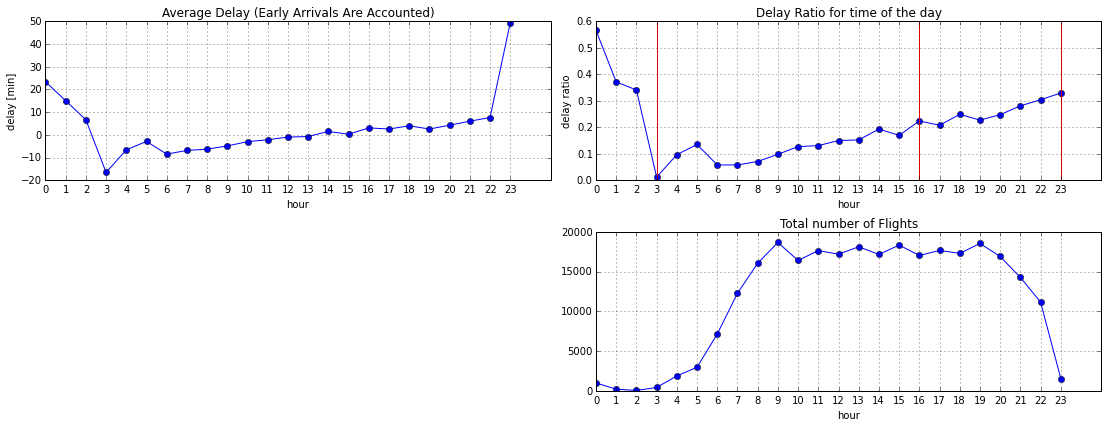

In [147]:
fig = plt.figure(figsize=(20/31*24,6))

plt.subplot(221)
plt.plot(avg_delay_time, 'o-')
plt.xticks(range(0,24),range(0,24))
plt.title('Average Delay (Early Arrivals Are Accounted)')
plt.ylabel('delay [min]')
plt.xlabel('hour')
plt.grid()

plt.subplot(222)
plt.plot(delay_ratio_time, 'o-')
plt.axvline(x = 3, color = 'r')
plt.axvline(x = 16, color = 'r')
plt.axvline(x = 23, color = 'r')
plt.xticks(range(0,24),range(0,24))
plt.title('Delay Ratio for time of the day')
plt.xlabel('hour')
plt.ylabel('delay ratio')
plt.grid()

plt.subplot(224)
plt.plot(total_flights_time[1:], 'o-')
plt.xticks(range(0,24),range(0,24))
plt.title('Total number of Flights')
plt.xlabel('hour')
fig.tight_layout()

plt.grid()
plt.show()



Inspired by the plots above we define the following categories for the hour of the day:

- morning: {03:00-12:00}
- afternoon: {13:00-16:00}
- evening: {17:00-22:00}
- night: {23:00-02:00}

In [169]:
#find the airlines within each category:
morning   = range(3,13)
afternoon = range(13,17)
evening   = range(17,23)
night     = [23,24,0,1,2]

## III. A Logistic Regression Model for Estimating the Delay Probabilities

In this section a logistic regression model for the estimation of delay probability is described and implemented. Let us start with a summary of variables identified in Section II:

- carrier: {no_unless_its_really_cheap, not_bad, way_to_go}
- arrival airport: coastal distance given in longitude
- day of the month: {good_day, bad_day, very_bad_day}
- time of the day: {morning, afternoon, evening, night}

We stick to the definition of delay (use only arrival delay) that we used when computing deate and time related patterns in Section III. Therefore we define target vector $Y$ with components equal to zero for on time flights and one for delayed flights.



In [206]:
#create the data set dictionary and target vector Y
from sklearn.feature_extraction import DictVectorizer

training_set = []
Y = []

N = len(delay_data_dict['ARR_DELAY'])

for i in range(N):

    lon = airport_info[delay_data_dict['DEST'][i]]['long']
    coastal_dist = abs(np.array(lon)-np.array(middle_of_map))

    arr_time = delay_data_dict['ARR_TIME'][i]
    if arr_time in morning:
        arr_time  = 'morning'
    elif arr_time in afternoon:
        arr_time = 'afternoon'
    elif arr_time in evening:
        arr_time= 'evening'
    else:
        arr_time = 'night'

    arr_day = delay_data_dict['DAY_OF_MONTH'][i]
    if arr_day in good_days:
        arr_day  = 'good_days'
    elif arr_day in bad_days:
        arr_day= 'bad_days'
    else:
        arr_day = 'very_bad_days'

    carrier = delay_data_dict['UNIQUE_CARRIER'][i]
    if carrier in no_unless_its_really_cheap:
        carrier = 'no_unless_its_really_cheap'
    elif carrier in not_bad:
        carrier = 'not_bad'
    else:
        carrier = 'way_to_go'

    training_set.append({'bias': 1.0,'coastal_dist': coastal_dist, 'arr_time': arr_time, 'arr_day': arr_day, 'carrier': carrier})
    Y.append(int(delay_data_dict['ARR_DELAY'][i]>15))

vec = DictVectorizer()
X   = vec.fit_transform(training_set).toarray()

In [207]:
#Train our Logistic Regression  Model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model = model.fit(X, Y)
train_accuracy = model.score(X, Y)

print('Training Accuracy:')
print(train_accuracy)

Training Accuracy:
0.820399558631


Using our model we seem to be correctly predicting delays 80% of the time. Now Let's split the data into training and test data sets with a 70/30 ratio, and see how we do with unseen data:

In [208]:
test_size  = int(0.3*N)
test_index = np.random.randint(N, size = test_size)

X_test  = [X[j] for j in range(N) if j in test_index]
X_train = [X[j] for j in range(N) if j not in test_index]
Y_test  = [Y[j] for j in range(N) if j in test_index]
Y_train = [Y[j] for j in range(N) if j not in test_index]

model = model.fit(X_train, Y_train)
train_accuracy = model.score(X_train, Y_train)
test_accuracy  = model.score(X_test, Y_test)

print('Training Accuracy:')
print(train_accuracy)
print('Test Accuracy:')
print(test_accuracy)

Training Accuracy:
0.820147922662
Test Accuracy:
0.821092919992


Fairly good test error reported above increases our confidence on our model. Finally let us report on the coefficients of the logistic regression model:

In [214]:
features = vec.get_feature_names()
coeffs = model.coef_[0]

print('%34s %20s' %('Feature:', 'Coefficient:'))
print('%34s %20s' %('-'*34, '-'*20))
for f,c in zip(features, coeffs):
    print(('%34s %20.4f' %(f, c)))

                          Feature:         Coefficient:
---------------------------------- --------------------
                  arr_day=bad_days              -0.1132
                 arr_day=good_days              -0.6516
             arr_day=very_bad_days               0.3040
                arr_time=afternoon              -0.3120
                  arr_time=evening               0.1429
                  arr_time=morning              -0.9635
                    arr_time=night               0.6718
                              bias              -0.4608
carrier=no_unless_its_really_cheap               0.0708
                   carrier=not_bad               0.0226
                 carrier=way_to_go              -0.5543
                      coastal_dist              -0.0063


An immediate comment on the coefficients of categorical variables our model: As we observed in Section II flying in the morning  of a 'good day' using an airline with good overall track record greatly reduces the risk of delay.

## IV. Conclusions and Some directions for future work

Analysis of on-time performance data of US domestic flights in December 2014 is conducted. We have identified key aspects that that could be used as features for a simple linear probability modeling of delays. We also reported on a logistic regression method for the estimation of delay probability using the identified features.

Here we ommit a more detailed analysis of coefficients of each feature. That type of analysis will definetely usefull in terms of importance of different features in predicting delay probabilities in the context of our logistic regression model.

Some possibilities to enhance the model and its performance can be listed as:

- Include interactions between predictions.
- Increase the granularity of the categorical variables.
- Try regularization. Within this category we also suggest the use of more features and Lasso type refularization for automatic feature selections
- Empleyment of model selection techniques such as cross-validation.
- Inclusion of data from years 2013 and 2012 as needed.
- Employment of other data sources such as precipitation and other wheather conditions.